## Mask R-CNN - BEP Model

### **Imports**

In [6]:
import os
import sys
import random
import math
import re
import time
import numpy as np # type: ignore
import tensorflow as tf # type: ignore
import matplotlib # type: ignore
import matplotlib.pyplot as plt # type: ignore 
import matplotlib.patches as patches # type: ignore
import cv2 # type: ignore

ROOT_DIR = os.path.abspath("../../")

sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

MODEL_DIR = os.path.join(ROOT_DIR, "ai_model_outputs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'DL_2DMaterials/DL_2DMaterials/ModelWeights_DL_2DMaterials/graphene_mask_rcnn_tdm_0120.h5') # Graphene COCO+2D

In [7]:
%load_ext autoreload
%autoreload 2
import bep_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### **Configurations**

In [8]:
import tdmcoco
config = tdmcoco.CocoConfig()
COCO_DIR = os.path.join(ROOT_DIR,'DL_2DMaterials/DL_2DMaterials/Dataset_DL_2DMaterials/Graphene') # Graphene


class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 3  # thin, few, thick
    DETECTION_MIN_CONFIDENCE = 0.7
config = InferenceConfig()
# config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=20):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### **Load data**

In [9]:
# dataset_tdm = tdmcoco.CocoDataset()
# dataset_tdm.load_coco(COCO_DIR, "val")
# dataset_tdm.prepare()

dataset_bep = bep_data.bepDataset()
dataset_bep.load_dir(os.path.join(ROOT_DIR, 'data'), 'test', reload_annotations=True)
dataset_bep.prepare()

print('')
# print("TDM Images: {}\nClasses: {}".format(len(dataset_tdm.image_ids), dataset_tdm.class_names))
print("BEP Images: {}\nClasses: {}".format(len(dataset_bep.image_ids), dataset_bep.class_names))


BEP Images: 3
Classes: ['BG', 'Mono_Graphene', 'Few_Graphene', 'Thick_Graphene']


### **Load Model**

In [5]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

weights_path = COCO_MODEL_PATH
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()

print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Instructions for updating:
Use fn_output_signature instead
Loading weights  c:\Users\abell\Documents\AA Delft\J4\BEP\ai\DL_2DMaterials/DL_2DMaterials/ModelWeights_DL_2DMaterials/graphene_mask_rcnn_tdm_0120.h5


### **Run Model**

In [23]:
image_id = random.choice(dataset_bep.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_bep, config, image_id, use_mini_mask=False)

info = dataset_bep.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_bep.image_reference(image_id)))

image ID: ali.0 (0) 


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



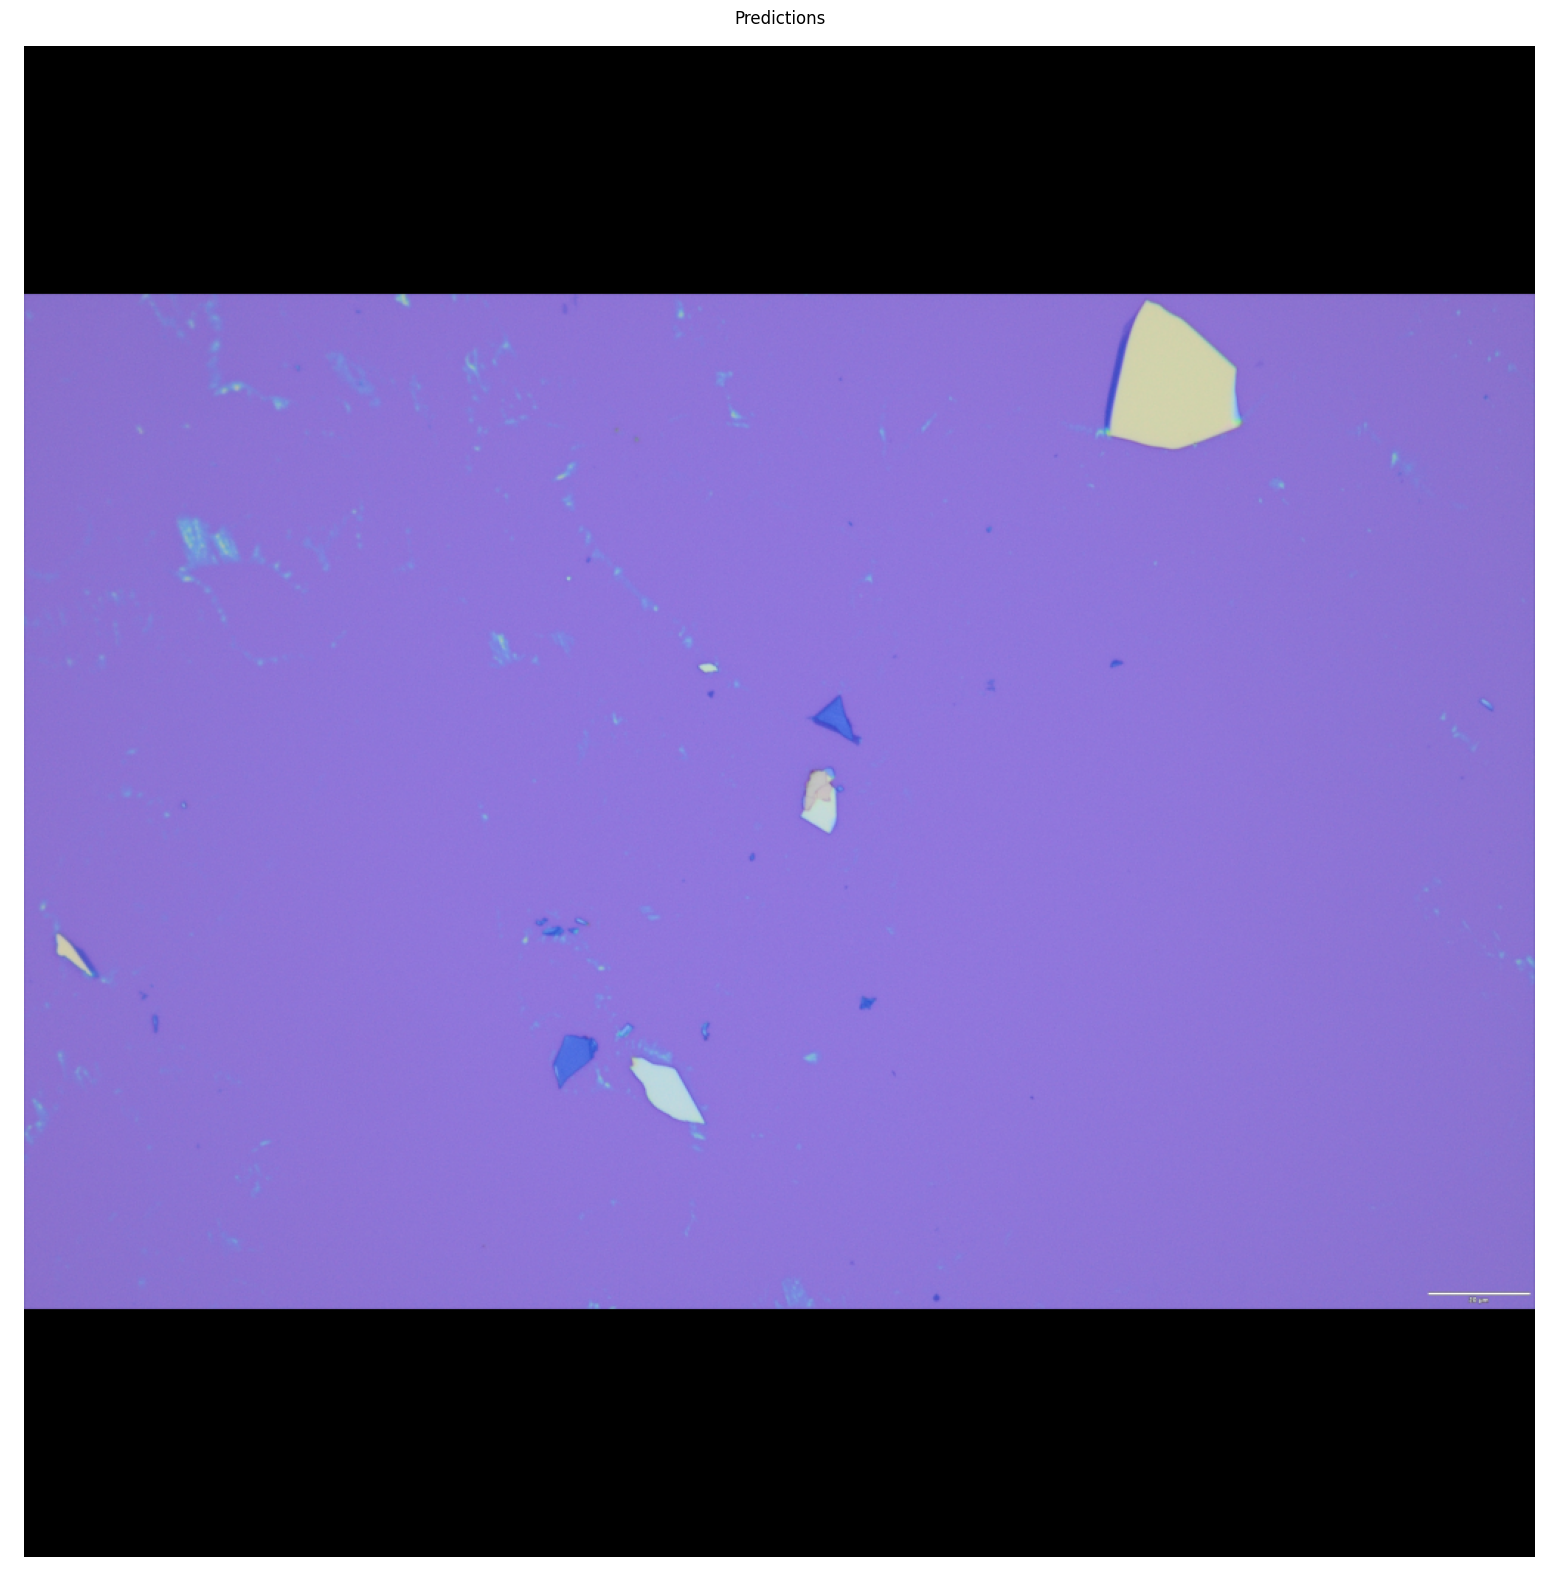

In [24]:
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
#visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                            dataset.class_names, r['scores'], ax=ax,
#                            title="Predictions")
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            ['','Mono', 'Few','Thick'], r['scores'], ax=ax,
                            title="Predictions")
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

### Ground Truth

image_id:  0 
Original shape:  (1721, 2560, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
mask                     shape: (1024, 1024, 7)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (7,)                  min:    2.00000  max:    3.00000  int32
[2 2 3 3 2 3 3]
bbox                     shape: (7, 4)                min:   22.00000  max:  826.00000  int32


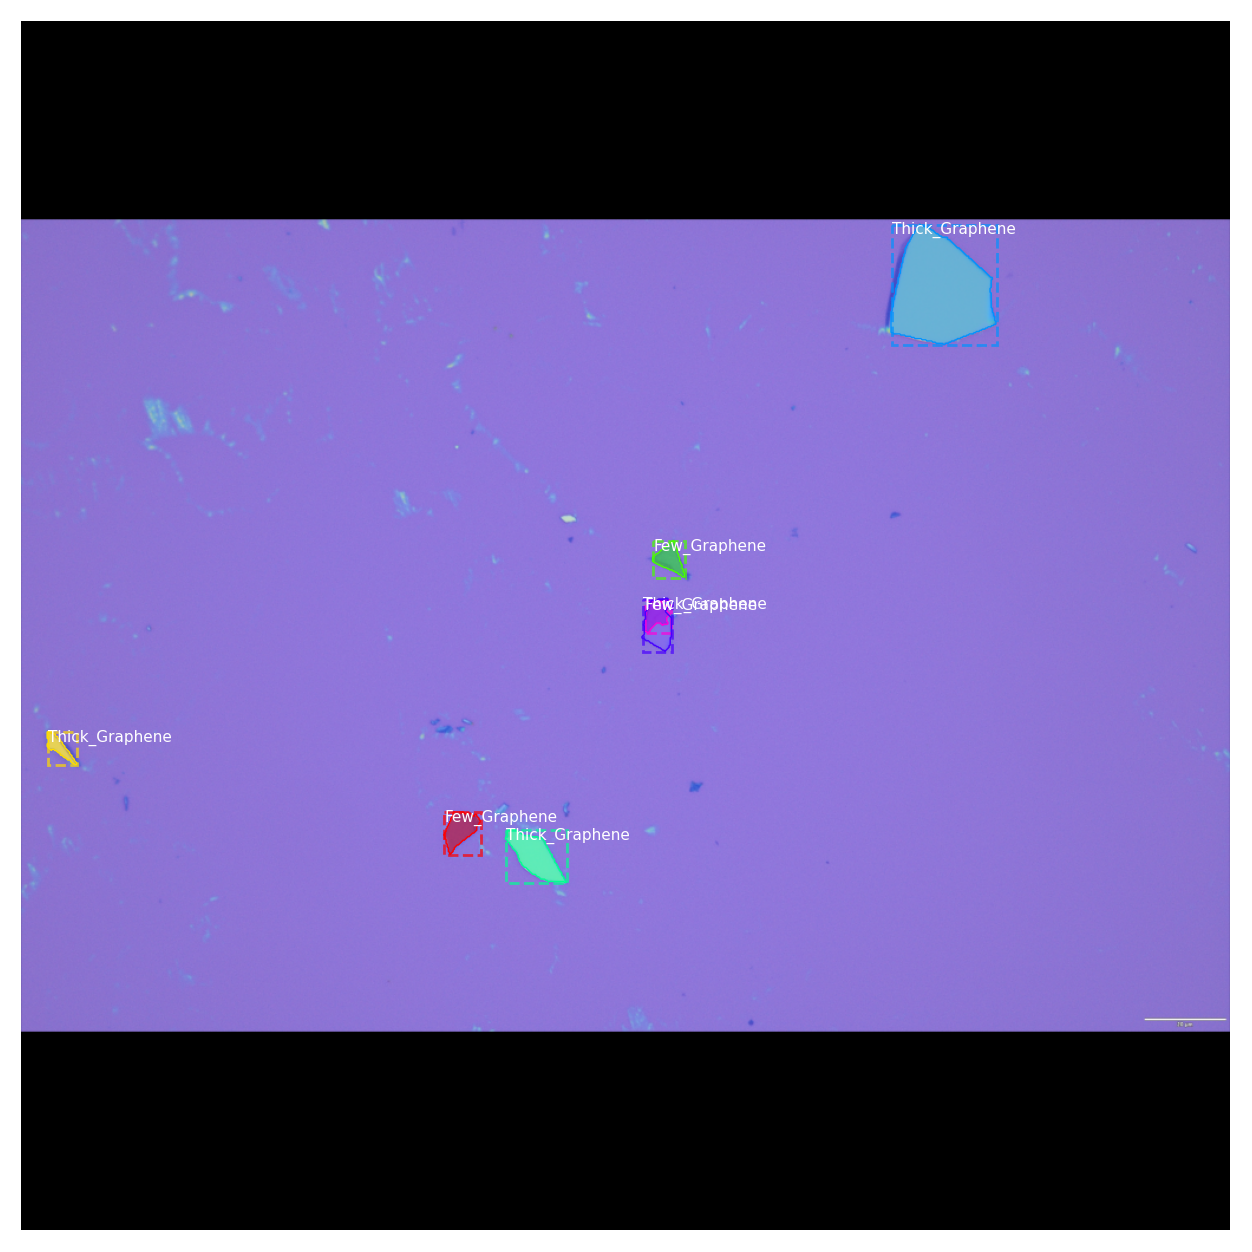

In [10]:
dataset_bep = bep_data.bepDataset()
dataset_bep.load_dir(os.path.join(ROOT_DIR, 'data'), 'test', reload_annotations=True)
dataset_bep.prepare()

dataset = dataset_bep
image_id = random.choice(dataset.image_ids)

image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
print(class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)